## Fléau de la dimension pour les plus proches voisins
La fonction suivante permet de générer un échantillon d’apprentissage et un échantillon test selon le modèle:
$$Y = X_1^2 + ... + X_p^2 + \epsilon$$
où les $X_j$ sont uniformes i.i.d de loi uniorme sur [0,1] et le bruit $\epsilon$ suit une loi $\mathcal{N}(0,0.52)$.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))

In [2]:
simu <- function(napp=300,ntest=500,p=3,graine=NULL){
  if (!is.null(graine)){set.seed(graine)}
  n <- napp+ntest
  X <- matrix(runif(n*p),ncol=p)
  Y <- apply(X^2,1,sum)+rnorm(n,sd=0.5)
  Yapp <- Y[1:napp]
  Ytest <- Y[-(1:napp)]
  Xapp <- data.frame(X[1:napp,])
  Xtest <- data.frame(X[-(1:napp),])
  return(list(Xapp=Xapp,Yapp=Yapp,Xtest=Xtest,Ytest=Ytest))
}
df <- simu(napp=300,ntest=500,p=3,graine=1234)

Construire la fonction `sel.k` qui admet en entrée :

- une grille de valeurs possibles de plus proches voisins (un vecteur).
- une matrice $X_{app}$ de dimension $n×p$ qui contient les valeurs variables explicatives.
- un vecteur $Y_{app}$ de dimension $n$ qui contient les valeurs de la variable à expliquer
- et qui renvoie en sortie la valeur de $k$ dans la grille qui minimise l’erreur LOO

In [3]:
sel.k <- function(grid, X, y){
    error <- c()
    for (k in grid){
        model <- FNN::knn.reg(train=X,y=y,k=k)
        error <- c(error, model$PRESS/max(c(nrow(X),1)))
    }
    return(grid[which.min(error)])
}

Une fois la fonction créée, on peut calculer l’erreur de l’estimateur sélectionné sur un échantillon test avec

In [4]:
k.opt <- sel.k(seq(1,50,by=5),df$Xapp,df$Yapp)
prev <- FNN::knn.reg(train=df$Xapp,y=df$Yapp,test=df$Xtest,k=k.opt)$pred
mean((prev-df$Ytest)^2)

[1] 0.283869

On souhaite comparer les erreurs des règles des $k$ plus proches voisins en fonction de la dimension. On considère 4 dimensions collectées dans le vecteur `DIM` et la grille de valeurs de $k$ suivantes :

- `DIM <- c(1,5,10,50)`
- `K_cand <- seq(1,50,by=5)`

Pour chaque valeur de dimension répéter `B = 100` fois :

- simuler un échantillon d’apprentissage de taille 300 et test de taille 500
- calculer la valeur optimale de $k$ dans `K_cand` grâce à `sel.k`
- calculer l’erreur de l’estimateur sélectionné sur un échantillon test.

In [5]:
result <- expand.grid(list(p = c(1,10,25,50,75,100,200), b = 1:100))
K_cand <- seq(1,50,by=5)
error <- c()
for (row in 1:nrow(result)){
    df <- simu(p = result[row, "p"])
    k.opt <- sel.k(K_cand,df$Xapp,df$Yapp)
    prev <- FNN::knn.reg(train=df$Xapp,y=df$Yapp,test=df$Xtest,k=k.opt)$pred
    error <- c(error, mean((prev-df$Ytest)^2))
}
result <- result %>% mutate(error = error)

A l’aide d’indicateurs numériques et de boxplots, comparer la distribution des erreurs en fonction de la dimension.

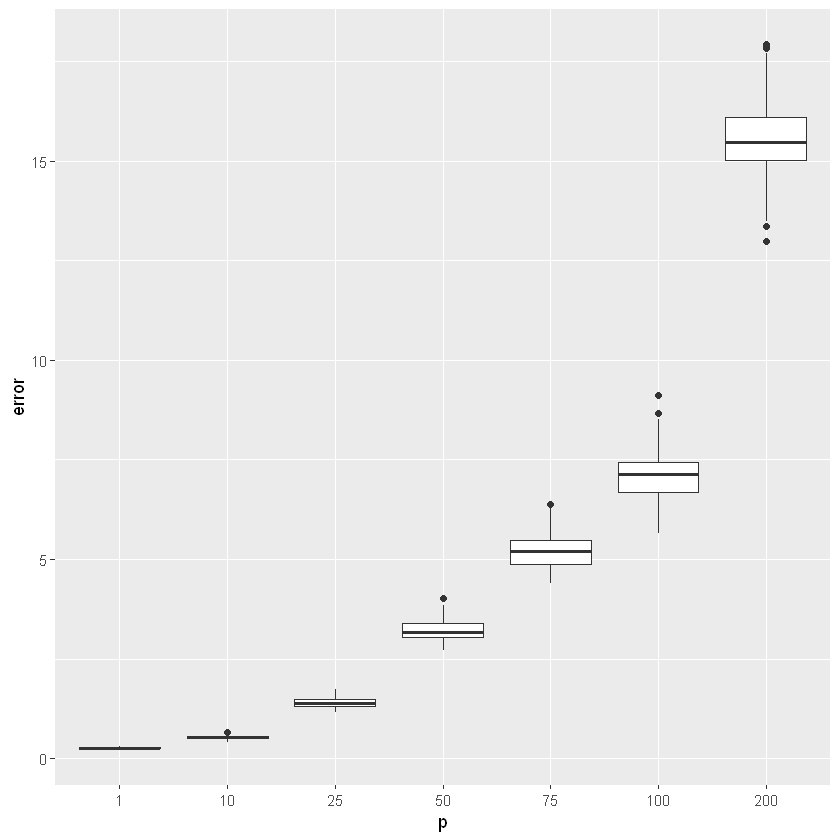

In [6]:
result %>% mutate(p = as.factor(p)) %>% 
ggplot() + aes(x = p, y = error) + geom_boxplot()

## Influence de la dimension dans le modèle linéaire
En vous basant sur l’exercice précédent, proposer une illustration qui peut mettre en évidence la précision d’estimation dans le modèle linéaire en fonction de la dimension. On pourra par exemple considérer le modèle linaire suivant:
$$Y = X_1 + 0X_2 + ... + 0X_p + \epsilon$$
et étudier la performance de l’estimateur MCO du coefficient de X1 pour différentes valeurs de p. Par exemple avec p dans le vecteur  
`DIM <- c(1,50,100,200)`

Les données pourront être générées avec la fonction suivante:

In [7]:
simu.lin <- function(n = 200, p = 1000, graine = NULL){
    X <- matrix(runif(n*p),ncol=p)
    if (!is.null(graine)){set.seed(graine)}
    Y <- X[,1]+rnorm(nrow(X),sd=0.5)
    df <- data.frame(Y,X)
    return(df)
}

In [8]:
result <- expand.grid(list(p = c(1,10,25,50,75,100,200), b = 1:100))
value <- c()
for (row in 1:nrow(result)){
    model <- lm(Y~., data = simu.lin(p = result[row, "p"], graine = 0))
    value <- c(value, model$coefficients[2])
}
result <- result %>% mutate(X1 = value)

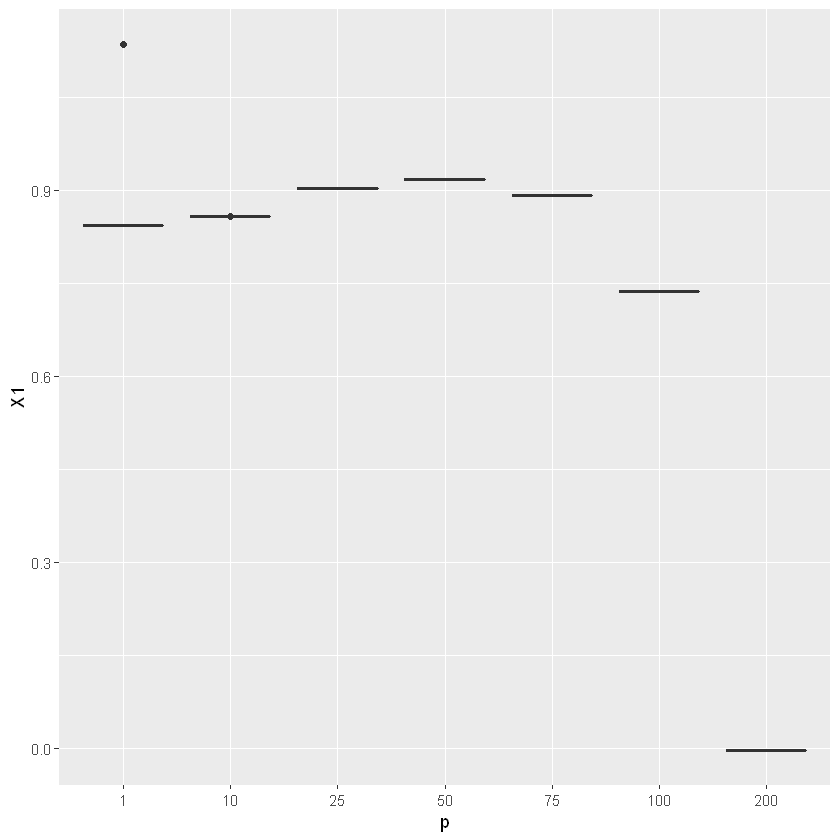

In [9]:
result %>% mutate(p = as.factor(p)) %>% 
ggplot() + aes(x = p, y = X1) + geom_boxplot()